# QUBOLS Solver Performance Analysis

We test here the QUBOLS SOLVER in isolation to explore its performance.

Wr first define the system we want to explore

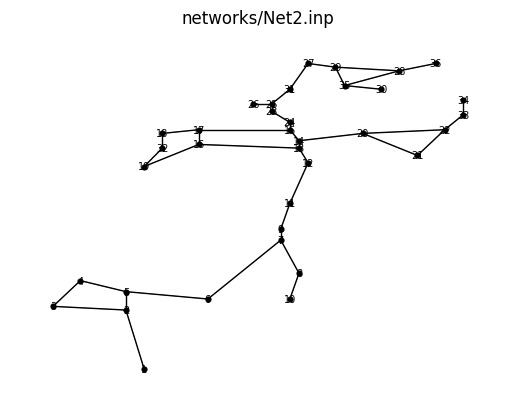

<Axes: title={'center': 'networks/Net2.inp'}>

In [26]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = "networks/Net2.inp"
# inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

In [27]:
wn.num_nodes

36

We then solve it with the internal Cholesky solver implemented in WNTR Quantum

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Solving the linear system Ax = b with:
A =  [[ 0.237 -0.197  0.     0.     0.    -0.04 ]
 [-0.197  1.072 -0.875  0.     0.     0.   ]
 [ 0.    -0.875  2.183 -1.268  0.    -0.04 ]
 [ 0.     0.    -1.268  2.636 -0.097  0.   ]
 [ 0.     0.     0.    -0.097  0.137 -0.04 ]
 [-0.04   0.    -0.04   0.    -0.04   0.119]]
b =  [ -1.62   -2.846  -1.098 874.005  -0.911  -2.558]
x =  [658.381 669.426 675.172 680.968 663.65  644.233]
residue =  3.2627186193895914e-13
Solving the linear system Ax = b with:
A =  [[ 0.074 -0.055  0.     0.     0.    -0.019]
 [-0.055  0.32  -0.265  0.     0.     0.   ]
 [ 0.    -0.265  0.617 -0.344  0.    -0.008]
 [ 0.     0.    -0.344  0.635 -0.023  0.   ]
 [ 0.     0.     0.    -0.023  0.035 -0.011]
 [-0.019  0.    -0.008  0.    -0.011  0.038]]
b =  [ -1.059  -1.748  -0.636 183.958  -0.53   -1.43 ]
x =  [613.591 641.499 653.909 666.823 626.029 588.157]
residue =  3.751

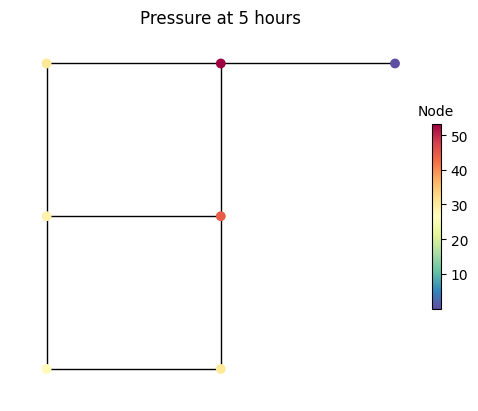

<Axes: title={'center': 'Pressure at 5 hours'}>

In [9]:
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node["pressure"].loc[0, :]
wntr.graphics.plot_network(
    wn,
    node_attribute=pressure_at_5hr,
    node_size=50,
    title="Pressure at 5 hours",
    node_labels=False,
)

The last matrix of the Newton Raphson has been stored in the `tmp` directory of EPANET. We can load it to further analyze how VQLS performs on it.

In [10]:
import sys
import os

epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]
util_path = os.path.join(epanet_path, "src/py/")
sys.path.append(util_path)

from quantum_linsolve import load_json_data

A, b = load_json_data(os.path.join(epanet_tmp, "smat.json"))

In [15]:
from quantum_newton_raphson.qubo_solver import QUBO_SOLVER

qubols = QUBO_SOLVER(
    num_qbits=11,
    num_reads=500,
    # iterations=5,
    range=100,
    offset=600,
    # temperature=1e4,
    use_aequbols=False,
)

We can solve the system using VQLS

In [16]:
res = qubols(A.todense(), b)

And plot the vqls solution compared to the LU solution

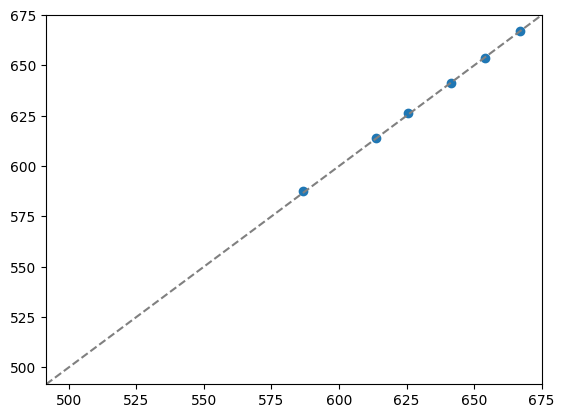

In [17]:
import numpy as np
import matplotlib.pyplot as plt

ref = np.linalg.solve(A.todense(), b)

plt.scatter(ref, res.solution)
plt.axline((500, 500), slope=1, linestyle="--", color="gray")
plt.show()